In [1]:
''' Import Initially Relevant Functions/Classes '''

import pandas as pd
import numpy as np
from lxml import objectify
import xml.etree.ElementTree as et 

from collections import defaultdict
from sklearn.metrics import mean_squared_error, confusion_matrix, log_loss, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier


import matplotlib.pyplot as plt
plt.style.use('ggplot')

# General CPC Categorization


A:     Human Necessities  

B:     Performing Operations, Transporting  

C:     Chemistry, Metallurgy  

D:     Textiles, Paper  

E:     Fixed Constructions  

F:     Mechanical Engineering; Heating, Lighting, Weapons, Blasting  

G:     Physics  

H:     Electricity  

Y:     GENERAL TAGGING OF NEW TECHNOLOGICAL DEVELOPMENTS; GENERAL TAGGING OF CROSS-SECTIONAL TECHNOLOGIES SPANNING OVER SEVERAL SECTIONS OF THE IPC; TECHNICAL SUBJECTS COVERED BY FORMER USPC CROSS-REFERENCE ART COLLECTIONS [XRACs] AND DIGESTS  


# https://www.uspto.gov/web/patents/classification/cpc/html/cpc.html 

# https://developer.uspto.gov/product/patent-application-full-text-dataxml#:~:text=USPTO%20Datasets&text=The%20file%20format%20is%20eXtensible,Document%20Type%20Definition%20(DTD)

In [2]:
'''Seperate individual XML files from USPTO caches (in terminal)''' 

    #csplit -f 'patent-' -b '%02d.xml' ipgb20191226.xml '/^<?xml /' '{*}'

'Seperate individual XML files from USPTO caches (in terminal)'

In [3]:
def make_df(path):
    ''' 
    Creates a Pandas DataFrame from single xml file from the United States Postal and Trademark Office given a pre-specified set of criteria.
    
    Input: file path
    
    Output: a Pandas DataFrame with columns:
        title, country, doc_number, section, class1, date, abstract, description 
    
    '''
    
    xtree = et.parse(path)
    xroot = xtree.getroot()
    
    title = ''
    country = ''
    doc_number = ''
    section = ''
    class1 = ''
    date = ''
    abstract = ''
    description = ''

    for A in xroot:
        if A.tag == 'us-bibliographic-data-application':
            for a1 in A:
                if a1.tag == 'publication-reference':
                    for a2 in a1:
                        if a2.tag == 'document-id':
                            for a3 in a2:
                                if a3.tag == 'country':
                                    country += a3.text
                                if a3.tag == 'doc-number':
                                    doc_number += a3.text
                                if a3.tag == 'date':
                                    date += a3.text
            
                if a1.tag == 'classifications-cpc':
                    for a2 in a1:
                        if a2.tag == 'main-cpc':
                            for a3 in a2:
                                if a3.tag == 'classification-cpc':
                                    for a4 in a3:
                                        if a4.tag == 'section':
                                            section += a4.text
                                        if a4.tag == 'class':
                                            class1 += a4.text
                        
                if a1.tag == 'invention-title':
                    title += a1.text
                
        if A.tag == 'abstract':
            for a1 in A:
                if type(a1.text) == str: 
                    abstract += a1.text
    
        if A.tag == 'description':
            for a1 in A:
                if type(a1.text) == str: 
                    description += ' ' + a1.text
    
    
    df = pd.DataFrame({'title' : [title],
                  'country' : [country],
                  'doc_number' : [doc_number],
                   'section' : [section],
                   'class' : [class1],
                  'date' : [date],
                  'total_text' : [abstract + description]})
    
    
    return(df)

In [4]:
def get_print(path):
    ''' 
    Creates rudimentary text schema from single United States Postal and Trademark Office xml file given a pre-specified set of criteria.
    
    Input: file path
    
    Output: A text schema of four relative layers. 
    
    '''
    xtree = et.parse(path)
    xroot = xtree.getroot() 

    for index, item in enumerate(xroot):
        print(index, ',', item.tag, ':', item.text)
        if item.tag == 'us-bibliographic-data-application':
            for i1, a in enumerate(item):
                print('    ', i1, ',', a.tag, ':', a.text)
                if a.tag == 'publication-reference':
                    for ib1, b1 in enumerate(a):
                        print('        ',ib1, ',', b1.tag, ':', b1.text)
                        if b1.tag == 'document-id':
                            for ib2, b2 in enumerate(b1):
                                print('            ',ib2, ',', b2.tag, ':', b2.text)
                               
            
                if a.tag == 'classifications-cpc':
                    for i2, a1 in enumerate(a):
                        print('        ',i2, ',', a1.tag, ':', a1.text)
                        if a1.tag == 'main-cpc':
                            for i3, a2 in enumerate(a1):
                                print('            ', i3, ',', a2.tag, ':', a2.text)
                                if a2.tag == 'classification-cpc':
                                    for i4, a3 in enumerate(a2):
                                        print('                  ', i4, ',', a3.tag, ':', a3.text)
                                        
                        
                if a.tag == 'invention-title':
                    print(a.text)
                    
                
        if item.tag == 'abstract':
            for i2, a1 in enumerate(item):
                print('        ',i2, ',', a1.tag, ':', a1.text)
        
    
        if item.tag == 'description':
            for i2, a1 in enumerate(item):
                print('        ',i2, ',', a1.tag, ':', a1.text)

In [5]:
''' Instantiate A Dataframe of Initial 9 XML files in USPTO XML Data Cache '''

df = make_df("data/20200604_uspto_patents/patent-01.xml")
for i in range(2,10):
    df_new = make_df(f"data/7526_patents/patent-0{i}.xml")
    df_change = df.append(df_new,ignore_index=True)
    df = df_change

In [6]:
''' Populate the Dataframe with Remaining ~ 8,515 Files in USPTO XML Data Cache '''

for i in range(10,8515):
    df_new = make_df(f"data/20200604_uspto_patents/patent-{i}.xml")
    df_change = df.append(df_new,ignore_index=True)
    df = df_change

In [61]:
df.replace('',np.NaN, inplace=True)
df.isnull().sum()

title         229
country       229
doc_number    229
section       250
class         250
date          229
total_text    229
dtype: int64

In [7]:
''' Identify and Drop Null Values (~ 229)'''
df.replace('',np.NaN, inplace=True)
df.dropna(inplace=True)
df.reset_index(inplace = True)
df.drop(columns=['index'], inplace=True)
df['class'] = df['class'].apply(pd.to_numeric)

In [2]:
'''CheckPoint: Save Processed Data'''

# df.to_csv('data/xmlprocessed200604.csv')
# df = pd.read_csv('data/xmlprocessed200604.csv',index_col=0)

In [104]:
''' Create a Dictionary with Section Classes '''

class_list = df.section.unique()

class_dict = {}
for des in class_list:
    ddf = df[df.section == des]   # create a dummy df for each Catergorization 'Class' 
    class_dict[des] = ddf['class'].unique()   # populate the dictionary with Section 'Classes'
    print(f"section {des} has {len(ddf['class'].unique())} different classes")

section A has 15 different classes
section B has 35 different classes
section C has 17 different classes
section D has 8 different classes
section E has 7 different classes
section F has 16 different classes
section G has 13 different classes
section H has 5 different classes


In [105]:
''' Create DataFrames for each Section '''

# df_list = [df_A, df_B, df_C, df_D, df_E, df_F, df_G, df_H]

df_A = df[df.section == 'A']
df_B = df[df.section == 'B']
df_C = df[df.section == 'C']
df_D = df[df.section == 'D']
df_E = df[df.section == 'E']
df_F = df[df.section == 'F']
df_G = df[df.section == 'G']
df_H = df[df.section == 'H']

<BarContainer object of 8 artists>

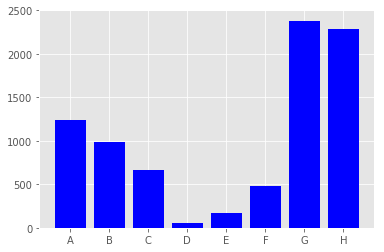

In [106]:
''' Create Bar Plot of Relative Recent Patent Section Classifciation Distribution '''

df_list = [df_A, df_B, df_C, df_D, df_E, df_F, df_G, df_H]

df_count_list = []
for df in df_list:
    df_count_list.append(len(df['total_text']))
    
x_c = class_list
y_c = df_count_list

plt.bar(x_c,y_c, color='b')

In [107]:
sorted_class_list = []

for k in sorted(df_count_list,reverse=True):
    for i,v in enumerate(df_count_list):
        if k == v:
            sorted_class_list.append(class_list[i])

In [108]:
df_count_list

[1238, 990, 661, 60, 168, 482, 2381, 2284]

Text(0, 0.5, 'Number of Patents')

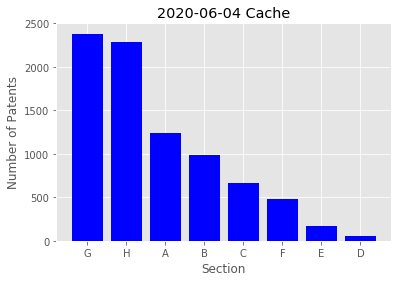

In [111]:
x_sc = sorted_class_list
y_sc = sorted(df_count_list,reverse=True)

plt.bar(x_sc,y_sc, color = 'blue')
plt.title("2020-06-04 Cache")
plt.xlabel('Section')
plt.ylabel('Number of Patents')

In [72]:
''' Create Dictionaries of DataFrames for each Class 
     
     Warning: There seems to be a bug here that ends up setting the main DataFrame (df) to 'H' 
     
     '''

# df_Adict = {}
# for item in class_dict['A']:
#     df_Adict[item] = df_A[df_A['class'] == item] # populate the dictionary with a dataframe for each class

# df_Bdict = {}
# for item in class_dict['B']:
#     df_Bdict[item] = df_B[df_B['class'] == item]
    
# df_Cdict = {}
# for item in class_dict['C']:
#     df_Cdict[item] = df_C[df_C['class'] == item]
    
# df_Ddict = {}
# for item in class_dict['D']:
#     df_Ddict[item] = df_D[df_D['class'] == item]

# df_Edict = {}
# for item in class_dict['E']:
#     df_Edict[item] = df_E[df_E['class'] == item]

# df_Fdict = {}
# for item in class_dict['F']:
#     df_Fdict[item] = df_F[df_F['class'] == item]
    
# df_Gdict = {}
# for item in class_dict['G']:
#     df_Gdict[item] = df_G[df_G['class'] == item]

# df_Hdict = {}
# for item in class_dict['H']:
#     df_Hdict[item] = df_H[df_H['class'] == item]

In [73]:
''' Begin Text Processing '''

' Begin Text Processing '

In [8]:
''' Inform Stop List and Word List'''
import nltk
from nltk.corpus import words
from nltk.corpus import stopwords
stop_list = set(stopwords.words('english'))
# nltk.download('words')
word_list = words.words()
word_list = set(word_list)

stop_list.add('n')

In [9]:
def preprocess_tokens1(string, word_list, stop_list):
    ''' Remove all unwanted identifiers from a string into format for Doc2Vec processing.
    input: dirty string, word_list (a list of all words in English language)
    output: clean string (punctuation, spacing, numbers, stopwords, urls removed)
    '''
    cleaned = string.lower().split()
    
    '''make sure every string in cleaned is is word list '''
    scrubbed = [item for item in cleaned if (item in word_list) and (item not in stop_list)]
    return scrubbed

In [10]:
def preprocess_tokens2(string, word_list, stop_list):
    ''' Remove all unwanted identifiers from a string into format for Tfidf Vectorization and categorization processing.
    input: dirty string, word_list (a list of all words in English language)
    output: clean string (punctuation, spacing, numbers, stopwords, urls removed)
    '''
    cleaned = string.lower().split()
    
    '''make sure every string in cleaned is is word list '''
    scrubbed = [item for item in cleaned if (item in word_list) and (item not in stop_list)]
    return " ".join(scrubbed)

In [11]:
''' Process text for Doc2Vec '''
df['text_processed1'] = df['total_text'].apply(lambda x: preprocess_tokens1(x, word_list, stop_list))

In [12]:
''' Process text for TFIDF '''
df['text_processed2'] = df['total_text'].apply(lambda x: preprocess_tokens2(x, word_list, stop_list))

In [3]:
# import pandas as pd
# import numpy as np
# from lxml import objectify
# import xml.etree.ElementTree as et 

# from collections import defaultdict
# from sklearn.metrics import mean_squared_error, confusion_matrix, log_loss, make_scorer
# from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
# from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
# from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
# from sklearn.linear_model import SGDClassifier


# import matplotlib.pyplot as plt
# plt.style.use('ggplot')

In [2]:
'''CheckPoint: Save Processed Data'''

# df.to_csv('data/textprocessed200604.csv')
# df = pd.read_csv('data/textprocessed200604.csv',index_col=0)

In [14]:
''' Continue to Develop a Document Similarity Model Using Gensim '''


from gensim import corpora
text = df['text_processed1']
texts = list(text.values)
dictionary = corpora.Dictionary(texts)    # create dictionary for total text
corpus = [dictionary.doc2bow(text) for text in texts]   # create corpus 

In [15]:
''' Employ Latent Semantic Indexing Model to Populate Vector Space '''

from gensim import models
lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=2)

In [16]:
def get_patent_from_number(number):
    ''' Prints relativley important data about a USPTO patent acround to the number in the XML download cache
    input: DataFrame number
    output: prints title, document number, section
    '''
    
    MS = df.iloc[number]
    print('Title :', MS['title'])
    print('Document Number : ', MS['doc_number'])
    print('Section :', MS['section'])
#     print('Description :', MS['total_text'])

In [27]:
''' Interface for Comparing Input Description'''

patent_inquiry = '''
An object of the present invention is to provide an apparatus for producing nanofibers and a nozzle head use for the same which can be manufactured by drilling and is capable of efficiently carrying molten resin on a gas flow.A nozzle head  TECHNICAL FIELD The present invention relates to an apparatus for producing nanofibers and a nozzle head used for the same. BACKGROUND OF THE INVENTION A conventional apparatus for producing nonwoven fabrics is disclosed in Patent Document 1. This apparatus for producing nonwoven fabrics comprises, as shown in  This melt blow unit  DESCRIPTION OF PRIOR ART Patent Literature Patent Literature 1: JP2010-185153A SUMMARY OF INVENTION Problems to be Solved by the Invention In the above-mentioned apparatus for producing nonwoven fabrics, however, the hot blast passages  The present invention was made in consideration of the above problems, and an object of the present invention is to provide an apparatus for producing nanofibers and a nozzle head use for the same which can manufacture by drilling and efficiently carry molten resin on a gas flow. Means for Solving the Problems According to the present invention, there is provided an apparatus for producing nanofibers comprising a raw material discharge surface on which a raw material flow passage for discharging a liquid raw material is arranged, and a gas discharge surface which is arranged with an angle α (0<α≤90°) toward said raw material discharge surface and on which a gas flow passage for ejecting gas is arranged, wherein said raw material flow passage is orthogonal to said raw material discharge surface, said gas flow passage is orthogonal to said gas discharge surface, and said raw material flow passage and said gas flow passage are arranged so that said liquid raw material discharged from said raw material flow passage meets gas ejected from said gas flow passage. According to the present invention, there is provided an apparatus for producing nanofibers comprising a raw material discharge surface on which a raw material flow passage for discharging a liquid raw material is arranged, a gas discharge surface which is arranged downwardly from said raw material discharge surface and on which a gas flow passage for ejecting gas is arranged, a connecting surface which is connected with said raw material discharge surface and said gas discharge surface, and is arranged with an angle β(0≤β<90°) toward said raw material discharge surface, wherein said raw material flow passage is orthogonal to said raw material discharge surface, said gas flow passage is orthogonal to said gas discharge surface, an opening of said gas flow passage contacts with said connecting surface, and said raw material flow passage and said gas flow passage are arranged so that said liquid raw material discharged from said raw material flow passage reaches to the opening of said gas flow passage along said connecting surface. According to the present invention, there is provided a nozzle head used for an apparatus for producing nanofibers comprising: a raw material discharge surface on which a raw material flow passage for discharging a liquid raw material is arranged, and a gas discharge surface which is arranged with an angle α (0<α≤90°) toward said raw material discharge surface and on which a gas flow passage for ejecting gas is arranged, wherein said raw material flow passage is orthogonal to said raw material discharge surface, said gas flow passage is orthogonal to said gas discharge surface, and said raw material flow passage and said gas flow passage are arranged so that said liquid raw material discharged from said raw material flow passage meets gas ejected from said gas flow passage. According to the present invention, there is provided a nozzle head used for an apparatus for producing nanofibers comprising: a raw material discharge surface on which a raw material flow passage for discharging a liquid raw material is arranged, a gas discharge surface which is arranged downwardly from said raw material discharge surface, and on which a gas flow passage for ejecting gas is arranged, a connecting surface which is connected with said raw material discharge surface and said gas discharge surface, and is arranged with an angle β (0≤β90°) toward said raw material discharge surface, wherein said raw material flow passage is orthogonal to said raw material discharge surface, said gas flow passage is orthogonal to said gas discharge surface, an opening of said gas flow passage contacts with said connecting surface, and said raw material flow passage and said gas flow passage are arranged so that said liquid raw material discharged from said raw material flow passage reaches to the opening of said gas flow passage along said connecting surface. Effect of the Invention According to the present invention, a raw material flow passage is formed so as to be orthogonal to a raw material discharge surface, and a gas flow passage is formed so as to be orthogonal to a gas discharge surface. Therefore, the raw material flow passage is formed on the raw material discharge surface by drilling and the gas flow passage is formed on the gas discharge surface. It becomes possible to join directly or indirectly with an angle the liquid raw material discharged from the raw material flow passage to a gas flow ejected from the gas flow passage through a connecting surface connected to the raw material discharge surface and the gas discharge surface. It can be achieved to manufacture precisely by drilling and to carry efficiently the liquid raw material on the gas flow. 
 DETAILED DESCRIPTION OF PREFERRED EMBODIMENTS The preferred embodiment of the present invention will be described hereinafter. The present invention is easily applicable to a structure other than the description of embodiments of the present invention within a scope not inconsistent with an object of the invention. According to the present invention, nanofibers are formed by supplying a liquid raw material to gas ejected under relatively high pressure. In the description, a term “gas” without specifying composition means gases consisting of any composition and a molecular structure. Additionally, in the description, a term “raw material” means all of materials applicable for forming the nanofibers. In the embodiments hereinafter, an explanation will be made for an example using synthetic resin as the “raw material”, but not limited to, various kinds of composition material will be usable. A term “liquid raw material” in the description does not limit property of the material to liquid. The “liquid raw material”, for example, includes “solvent” which is prepared by dissolving in advance a solid raw material or a liquid raw material as a solute in a predetermined solvent so that a predetermined concentration is obtained. Additionally, “liquid raw material” also includes “molten raw material” which the solid raw material is molten. In short, the “liquid raw material” of the present invention needs property having viscosity enough to supply (eject, discharge) “raw material” from supply holes (ejection holes, discharge holes), and the “raw material” having such liquid property is described as “liquid raw material” in the present invention. A basic concept of the present invention is, as shown in (I)  Additionally, as shown in (II)  Accordingly, the liquid raw material discharged from the raw material flow passage  In  Herein, the axis line P of the raw material flow passage  
 
 
 The raw material supply tangent angle α should be determined by the distance “a”, the distance “b”, and the distance “d”, and moreover, should be determined by relation among the opening diameter “c” of the high-pressure gas, pressure and temperature of the ejected gas the gas flow passage  Regarding an arrangement condition of the raw material flow passage  First Embodiment Hereinafter, an apparatus for producing nanofibers according to a first embodiment of the present invention will be described referring to  The apparatus for producing nanofibers  As shown in  As shown in  The nozzle head  In the present embodiments, the raw material flow passage  An opening on the back surface  The opening on the back surface  The such structure is only an example, and if there are provided the raw material flow passage  A description will be made of operation of the apparatus for producing nanofibers  According to the apparatus for producing nanofibers  It can be achieved to manufacture precisely by drilling and to carry efficiently the solvent on the gas flow. The apparatus for producing nanofibers  (Variation 1 of the First Embodiment) Variation 2 of the First Embodiment Variation 3 of the First Embodiment Variation 4 of the First Embodiment Variation 5 of the First Embodiment Variation 6 of the First Embodiment (Variation 7 of the First Embodiment) (Variation 8 of the First Embodiment) The first portion  (Variation 9 of the First Embodiment) (Variation 10 of the First Embodiment) The first portion  (Variation 11 of the First Embodiment) (Variation 12 of the First Embodiment) (Variation 13 of the First Embodiment) (Variation 14 of the First Embodiment) (Variation 15 of the First Embodiment) In Table 1, an outline of the basic structure and the structures of the variations 1 to 15 of the nozzle head  
 Second Embodiment Hereinafter, an apparatus for producing nanofibers according to a second embodiment of the present invention will be described referring to  The apparatus for producing nanofibers  The nozzle head  The nozzle head  The connecting surface  According to the present embodiment, the raw material flow passage  A description will be made of operation of the apparatus for producing nanofibers  According to the apparatus for producing nanofibers  Third Embodiment Hereinafter, an apparatus for producing nanofibers according to a third embodiment of the present invention will be described referring to  The apparatus for producing nanofibers  The apparatus for producing nanofibers  As shown in  The nozzle head  In the present embodiments, the raw material flow passage  A plurality of the raw material flow passages  A plurality of the gas flow passage  The such structure is only an example, and if there are provided the raw material flow passage  A description will be made of operation of the apparatus for producing nanofibers  According to the apparatus for producing nanofibers  (Variation 1 of the Third Embodiment) (Variation 2 of the Third Embodiment) (Variation 3 of the Third Embodiment) (Variation 4 of the Third Embodiment) The first portion  (Variation 5 of the Third Embodiment) The nozzle head  In the nozzle head  (Variation 6 of the Third Embodiment) (Variation 7 of the Third Embodiment) The nozzle head  In the nozzle head  (Variation 8 of the Third Embodiment) In table 2, an outline of the basic structure and the structures of the variations 1 to 8 of the nozzle head  
 Though description is made of the embodiments of the present invention in detail, the present invention is not limited to the prescribed embodiments, and various modifications may be possible within a scope of the present invention. For example, in the above embodiment, the horizontal apparatus for producing nanofibers is disclosed which the molten resin and the gas ejection hole are provided in a horizontal direction, however it is not limited to, and there is no problem to arrange the vertical apparatus and the nozzle head in the downward direction. Rather, such vertical apparatus is capable of efficiently preventing influence by the gravity. In each embodiment and variation, positions of the raw material flow passage and the gas flow passage may be replaced each other. Specifically, in the nozzle head  The extruding means is described as the screw, an intermittent extrusion with a piston by supplying solution sequentially such as a die casting may be applicable. The apparatus for producing nanofibers and the nozzle head according to the present invention preferably comprise a raw material temperature control function (not illustrated) in accordance with conditions of the liquid raw material and production of the nanofibers. The apparatus for producing nanofibers and the nozzle head according to the present invention preferably comprises a gas temperature control function (not illustrated) for controlling a temperature of the gas at the gas exit.

'''

In [28]:
''' Vectorize Inquiry for Latent Semantic Indexing '''

vec_bow = dictionary.doc2bow(patent_inquiry.lower().split())
vec_lsi = lsi[vec_bow]  # convert the query to LSI space
# print(vec_lsi)

In [29]:
''' Put the Index in LSI And Reference it '''

from gensim import similarities
index = similarities.MatrixSimilarity(lsi[corpus])  # transform corpus to LSI space and index it
index.save('data/inter_patent.index')
index = similarities.MatrixSimilarity.load('data/inter_patent.index')

sims = index[vec_lsi]  # perform a similarity query against the corpus

In [35]:
''' Return Top 5 Most Similar Patents to Patent Inquiry '''

sims = sorted(enumerate(sims), key=lambda item: -item[1])

# to include cosine similarity in print
for i in range(5):
    print(f"{i+1}, Document Similarity is {sims[i][1]}")
    get_patent_from_number(sims[i][0])
    print("     ")

    
# # to disclude cosine similarity in print
# for i in range(5):
#     print(f"{i+1},")
#     get_patent_from_number(sims[i][0])
#     print("     ")

1,
Title : NANOFIBER MANUFACTURING DEVICE AND HEAD USED FOR SAME
Document Number :  20200173057
Section : D
     
2,
Title : CONNECTOR FRAME
Document Number :  20200176903
Section : H
     
3,
Title : ELECTRICAL CONTACT AND CARRIER ASSOCIATED THEREWITH
Document Number :  20200176911
Section : H
     
4,
Title : SIGNAL PROCESSING METHOD AND IMAGING SYSTEM FOR SCATTER CORRECTION IN COMPUTED TOMOGRAPHY
Document Number :  20200170599
Section : A
     
5,
Title : Oral Care Compositions With Improved Tin Compatability
Document Number :  20200170897
Section : A
     


In [3]:
''' To Continue to Develope a Classification Model '''
from sklearn.feature_extraction.text import TfidfVectorizer

'''Create 'Corpa' and Vectorize the Tokens'''

corpa = df['text_processed2']
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpa.values)
X = X.todense()
y = df['section'].values

In [ ]:
''' Split the Data into Training and Test Sections '''

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23, stratify=y, test_size = 0.2)

In [ ]:
''' Train Predictive Clssification Models '''

In [27]:
#logistic model
lr = LogisticRegression(class_weight= 'balanced')
lr.fit(X_train, y_train);
lr_predict = lr.predict(X_test)
lr_score = lr.score(X_test, y_test)
print('Logistic Regression Model Score: {}'.format(lr_score))

Logistic Regression Model Score: 0.6938898971566848


In [28]:
#random forest
rf = RandomForestClassifier(class_weight='balanced',
                           n_estimators=100,
                           max_features='auto',
                           random_state=0, n_jobs=-1)
rf.fit(X_train, y_train);
rf_predict = rf.predict(X_test)
rf_score = rf.score(X_test, y_test)
print("Random Forest Model Score: {}".format(rf_score))

Random Forest Model Score: 0.6291591046581972


In [29]:
#stochastic gradient descent
sgd = SGDClassifier(class_weight="balanced")
sgd.fit(X_train, y_train);
# SGDClassifier(max_iter=5)
sgd_predict = sgd.predict(X_test)
sgd_score = sgd.score(X_test, y_test)
print("SGD Model Score: {}".format(sgd_score))

SGD Model Score: 0.7096188747731398


In [30]:
#naive_bayes
nb = MultinomialNB()
nb.fit(X_train, y_train);
nb_predict = nb.predict(X_test)
nb_score = nb.score(X_test, y_test)
print("NB Model Score: {}".format(nb_score))

NB Model Score: 0.5638233514821537


In [87]:
''' Run Vectorized Inquiry on Predictive Model '''

inquiry = [patent_inquiry.lower()]
classify = vectorizer.transform(inquiry)
classify = classify.todense()

sgd.predict(classify)

In [1]:
''' Potentially Useful But Unused Information '''

' Potentially Useful But Unused Information '

In [ ]:
# from gensim.models import doc2vec

# model = doc2vec.Doc2Vec(texts)

# from gensim.models import LsiModel

# model = LsiModel(corpus, id2word=dictionary)
# vectorized_corpus = model[corpus]  # vectorize input copus in BoW format

# X = vectorized_corpus
# y = df['section']

In [ ]:
# def remove_once(texts):
#     frequency = defaultdict(int)
#     for text in texts:
#         for token in text:
#             frequency[token] += 1
    
#     texts = [[token for token in text if frequency[token] > 1] for text in texts]

#     return texts

In [ ]:
# from nltk.cluster import KMeansClusterer
# from sklearn import cluster
# from sklearn import metrics# training datasentences = [[‘this’, ‘is’, ‘the’, ‘good’, ‘machine’, ‘learning’, ‘book’],
#             [‘this’, ‘is’,  ‘another’, ‘book’],
#             [‘one’, ‘more’, ‘book’],
#             [‘this’, ‘is’, ‘the’, ‘new’, ‘post’],
#           [‘this’, ‘is’, ‘about’, ‘machine’, ‘learning’, ‘post’],
#             [‘and’, ‘this’, ‘is’, ‘the’, ‘last’, ‘post’]]# training model

# model = Word2Vec(sentences, min_count=1)# get vector data
# X = model[model.wv.vocab]
# print (X)print (model.similarity(‘this’, ‘is’))print (model.similarity(‘post’, ‘book’))print (model.most_similar(positive=[‘machine’], negative=[], topn=2))print (model[‘the’])print (list(model.wv.vocab))print (len(list(model.wv.vocab)))NUM_CLUSTERS=3
# kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
# assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
# print (assigned_clusters)words = list(model.wv.vocab)
# for i, word in enumerate(words):
#     print (word + “:” + str(assigned_clusters[i]))kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
# kmeans.fit(X)labels = kmeans.labels_
# centroids = kmeans.cluster_centers_print (“Cluster id labels for inputted data”)
# print (labels)
# print (“Centroids data”)
# print (centroids)print (“Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):“)
# print (kmeans.score(X))silhouette_score = metrics.silhouette_score(X, labels, metric=‘euclidean’)print (“Silhouette_score: “)
# print (silhouette_score)

In [29]:
# def RFC_model(X_train, X_test, y_train, y_test, instance):
#     '''
#     input: training and testing sets
#     output: print log loss and score,
#             return: Random Forest model, y predictions
#     '''
#     rf = RandomForestClassifier(n_estimators=100,
#                            max_features='auto',
#                            random_state=0, n_jobs=-1)
#     rf.fit(X_train, y_train)
#     print(f"log loss for {instance} = {log_loss(y_test, rf.predict_proba(X_test))}")
#     print(f"accuracy of {instance} = {rf.score(X_test, y_test)}")
#     return rf, rf.predict(X_test)

In [ ]:
# >>> from sklearn.preprocessing import StandardScaler
# >>> from sklearn.pipeline import make_pipeline
# >>> X = np.array([[-1, -1], [-2, -1], [1, 1], [2, 1]])
# >>> Y = np.array([1, 1, 2, 2])
# >>> # Always scale the input. The most convenient way is to use a pipeline.
# >>> clf = make_pipeline(StandardScaler(),
# ...                     SGDClassifier(max_iter=1000, tol=1e-3))
# >>> clf.fit(X, Y)
# Pipeline(steps=[('standardscaler', StandardScaler()),
#                 ('sgdclassifier', SGDClassifier())])
# >>> print(clf.predict([[-0.8, -1]]))